In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from sklearn.metrics import auc
import pandas as pd
import glob
import os
import seaborn as sns
os.chdir(r'E:\AAA_Labwork\capenterlab_mtb')

In [3]:
from matplotlib.colors import LinearSegmentedColormap
values = [0,1]
colors = [(227, 227, 227), (255, 42, 18)]
norm = plt.Normalize(min(values), max(values))
my_cmap = LinearSegmentedColormap.from_list(
    '', [(norm(value), tuple(np.array(color) / 255)) for value, color in zip(values, colors)])

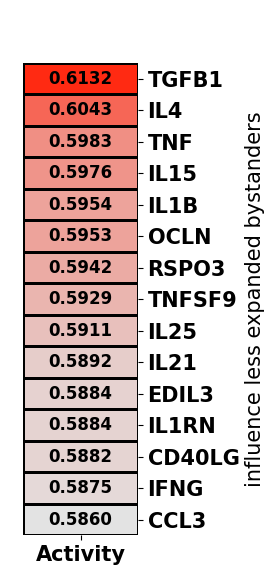

In [3]:
%matplotlib inline
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': my_cmap}

plot_df = pd.read_csv('nichenet_result.csv', sep=" ", index_col= "test_ligand").sort_values(by = "auroc", ascending= False)["auroc"]
plot_df = plot_df[plot_df>0.5][0:min(30,plot_df.shape[0])]
plot_df.index.name = 'influence less expanded bystanders'
plot_df.name = 'Activity'
clustergrid = sns.clustermap(plot_df[0:min(15,plot_df.shape[0])],figsize = (3,6),linewidths=2,
            linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5, cbar_pos= None,
            row_cluster = False,col_cluster = False,#cbar_kws={'label': 'NicheNet ligand activity (AUROC)','location':"left"},
            **kwargs)
# for a in clustergrid.ax_col_dendrogram.collections:
#     a.set_linewidth(2)
#     clustergrid.ax_cbar.set_position([-10, 0, -0.3, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

ax = clustergrid.ax_heatmap

# Extract data values and annotate each cell
for i in range(plot_df[0:15].shape[0]):  # Iterate over rows
    for j in range(1):  # Since there's only one column
        value = plot_df[0:15].iloc[i]  # Get value
        ax.text(j+0.5, i+0.5, f'{value:.4f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')



plt.savefig('ligand_vis.png',dpi = 300,bbox_inches='tight')

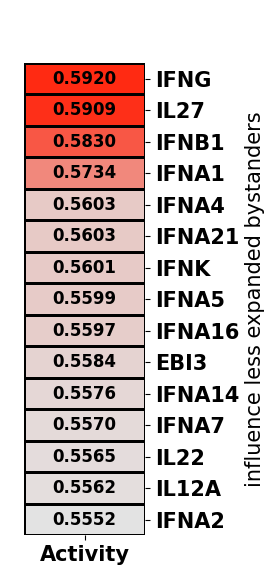

In [4]:
%matplotlib inline
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': my_cmap}

plot_df = pd.read_csv('nichenet_result_mtb1.csv', sep=" ", index_col= "test_ligand").sort_values(by = "auroc", ascending= False)["auroc"]
plot_df = plot_df[plot_df>0.5][0:min(30,plot_df.shape[0])]
plot_df.index.name = 'influence less expanded bystanders'
plot_df.name = 'Activity'
clustergrid = sns.clustermap(plot_df[0:min(15,plot_df.shape[0])],figsize = (3,6),linewidths=2,
            linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5, cbar_pos= None,
            row_cluster = False,col_cluster = False,#cbar_kws={'label': 'NicheNet ligand activity (AUROC)','location':"left"},
            **kwargs)
# for a in clustergrid.ax_col_dendrogram.collections:
#     a.set_linewidth(2)
#     clustergrid.ax_cbar.set_position([-10, 0, -0.3, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

ax = clustergrid.ax_heatmap

# Extract data values and annotate each cell
for i in range(plot_df[0:15].shape[0]):  # Iterate over rows
    for j in range(1):  # Since there's only one column
        value = plot_df[0:15].iloc[i]  # Get value
        ax.text(j+0.5, i+0.5, f'{value:.4f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')



plt.savefig('ligand_vis_mtb1.png',dpi = 300,bbox_inches='tight')

## not used - Calculate enrichment (auc)

C:\Users\16220\AppData\Local\Temp\ipykernel_8560\992597096.py:23: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  enrichment[nn_name][profile_celltype] = auc_value
C:\Users\16220\AppData\Local\Temp\ipykernel_8560\992597096.py:23: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  enrichment[nn_name][profile_celltype] = auc_value
C:\Users\16220\AppData\Local\Temp\ipykernel_8560\992597096.py:23: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[p

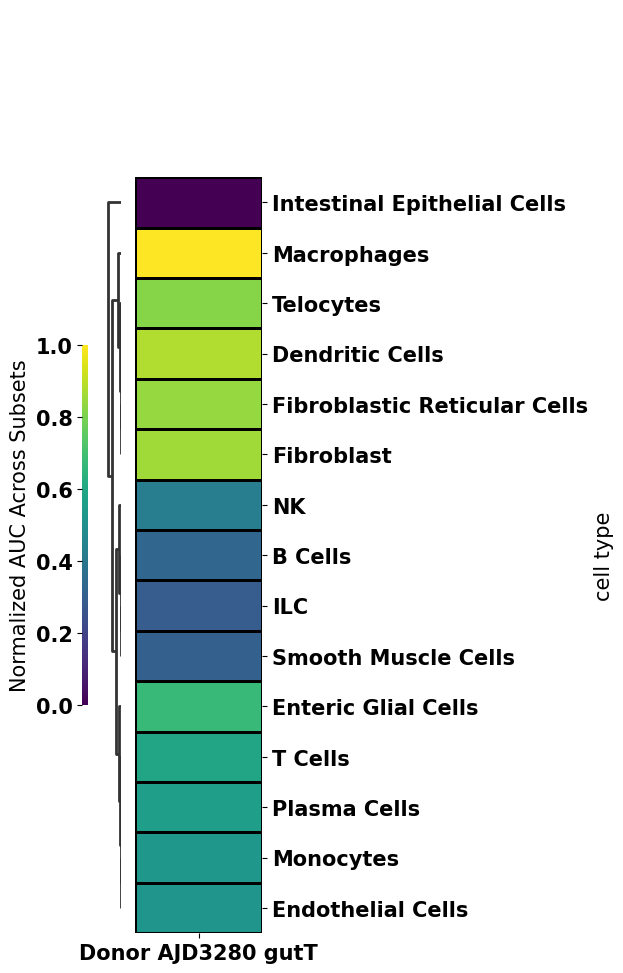

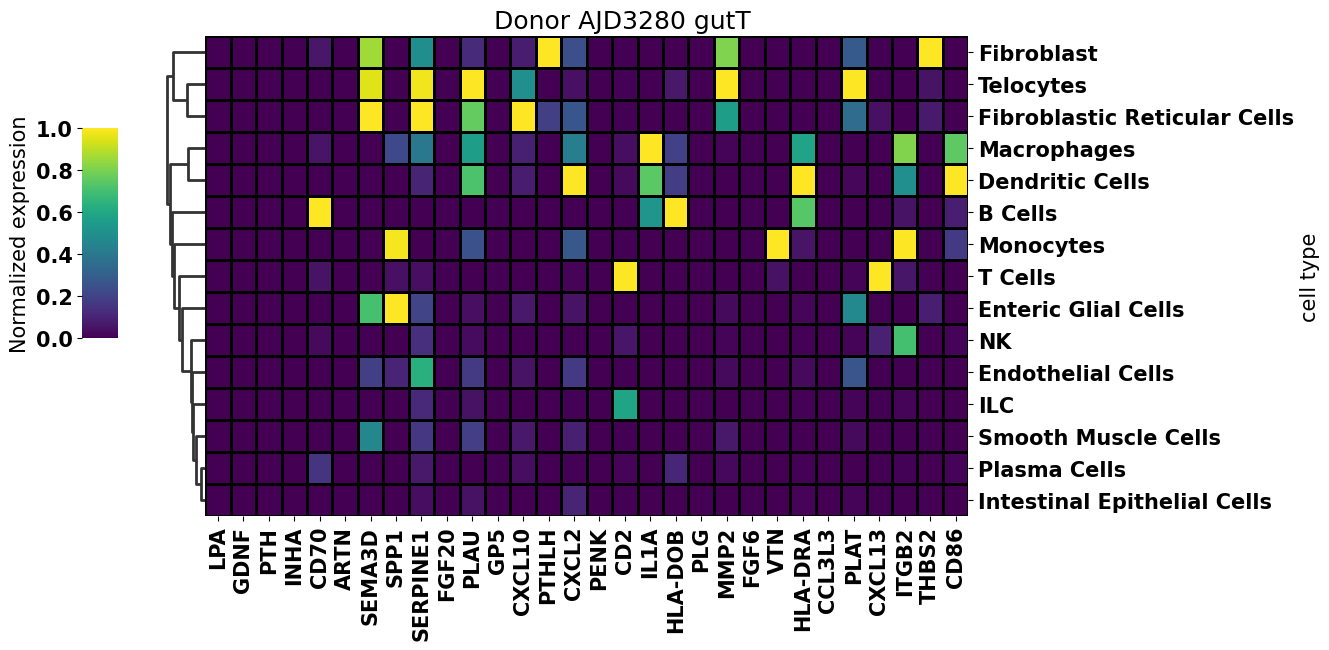

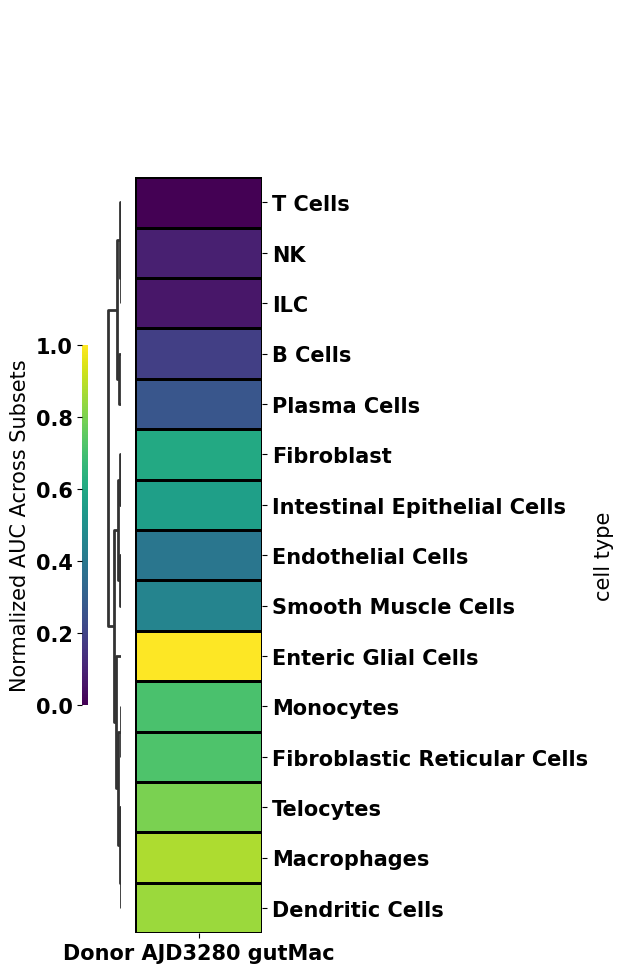

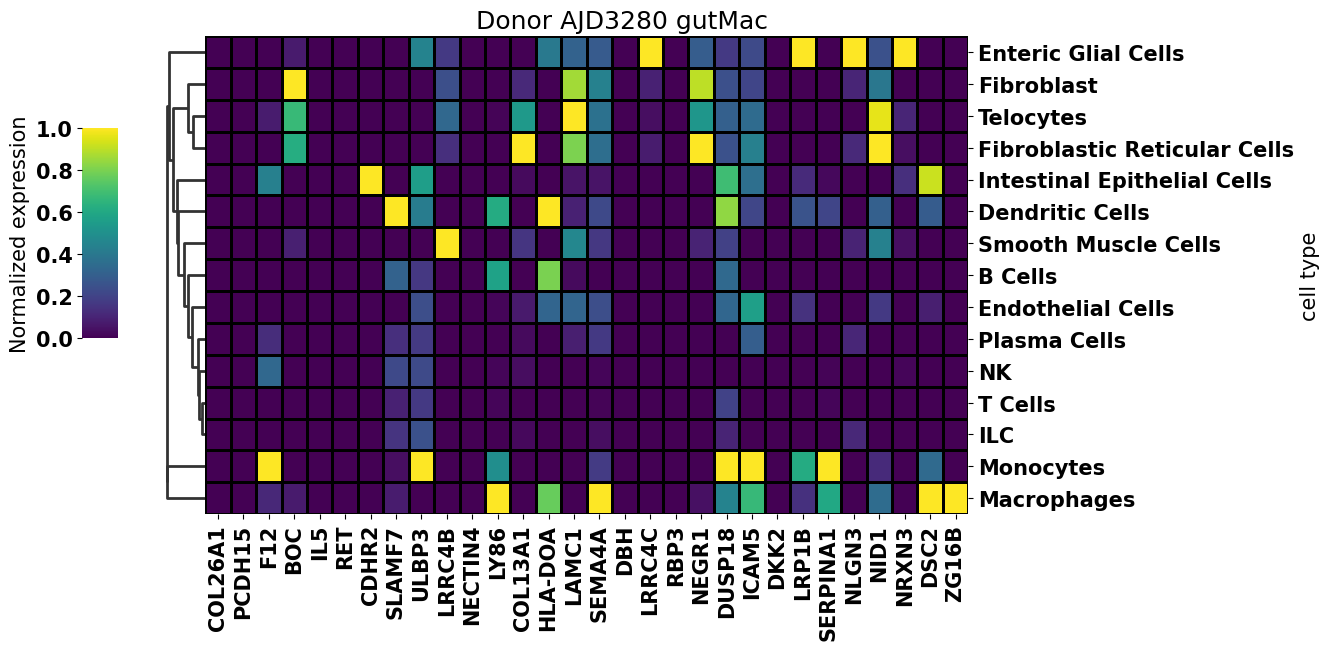

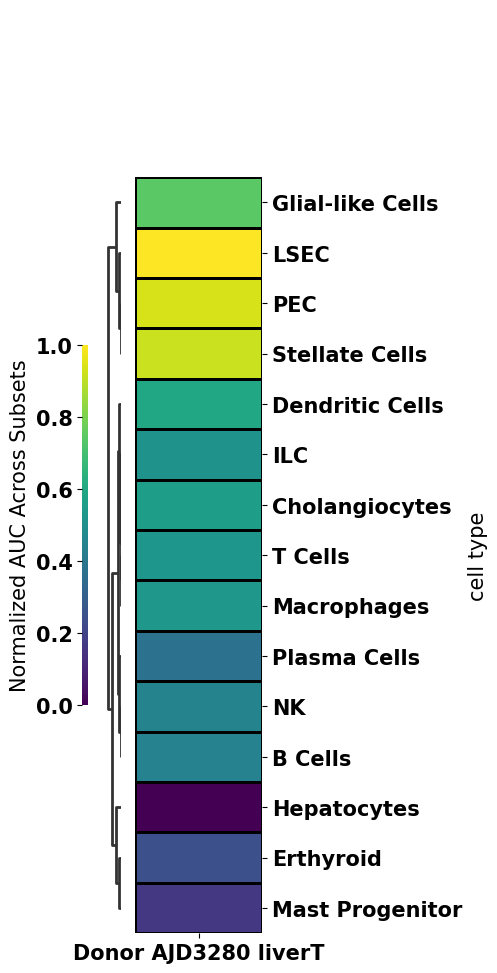

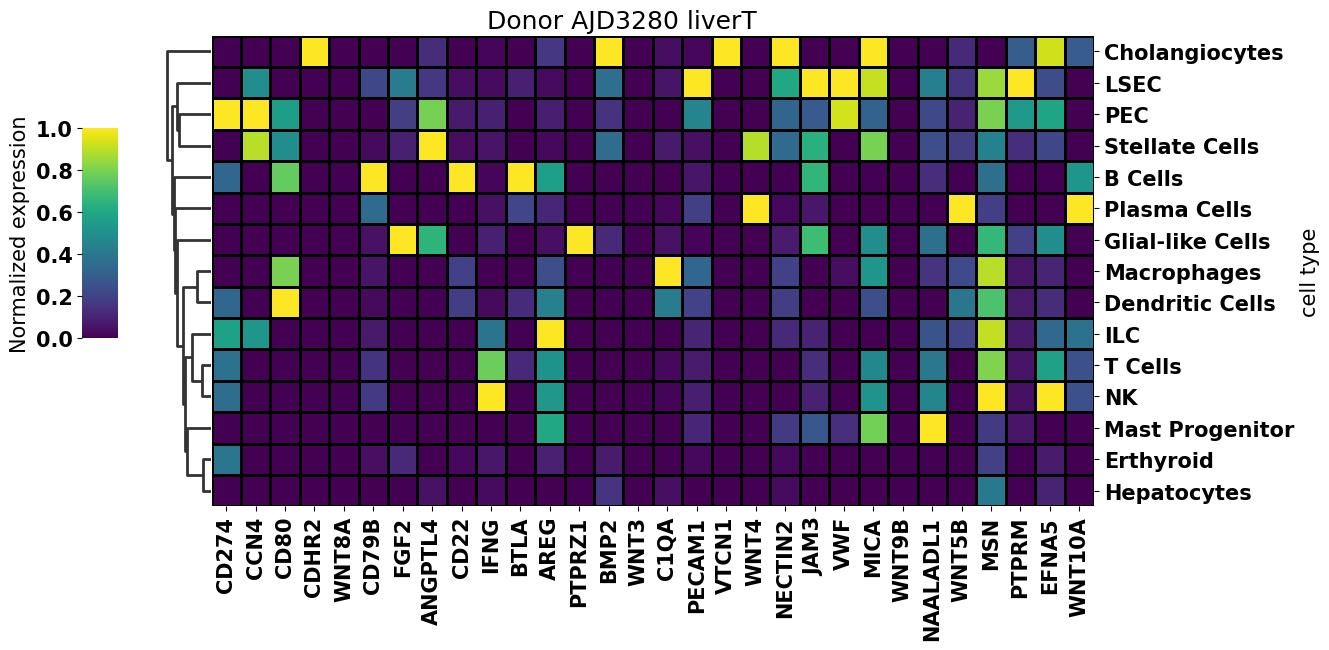

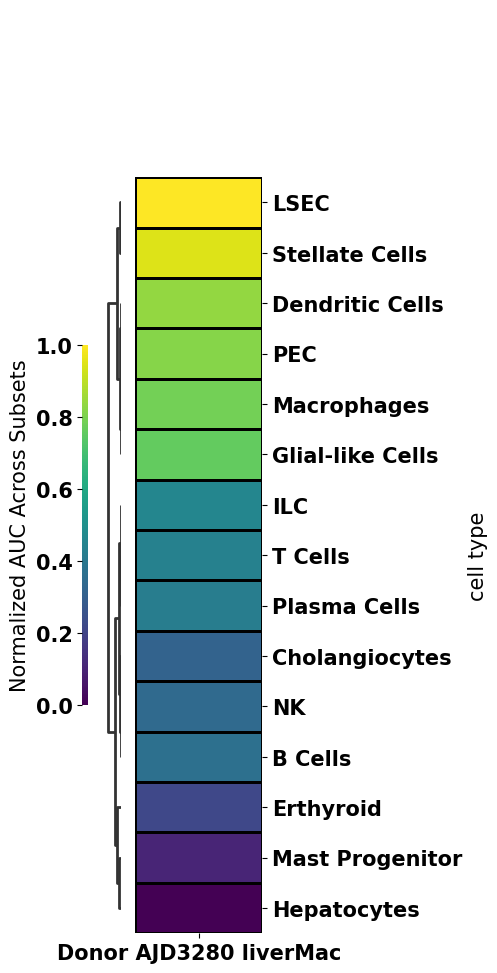

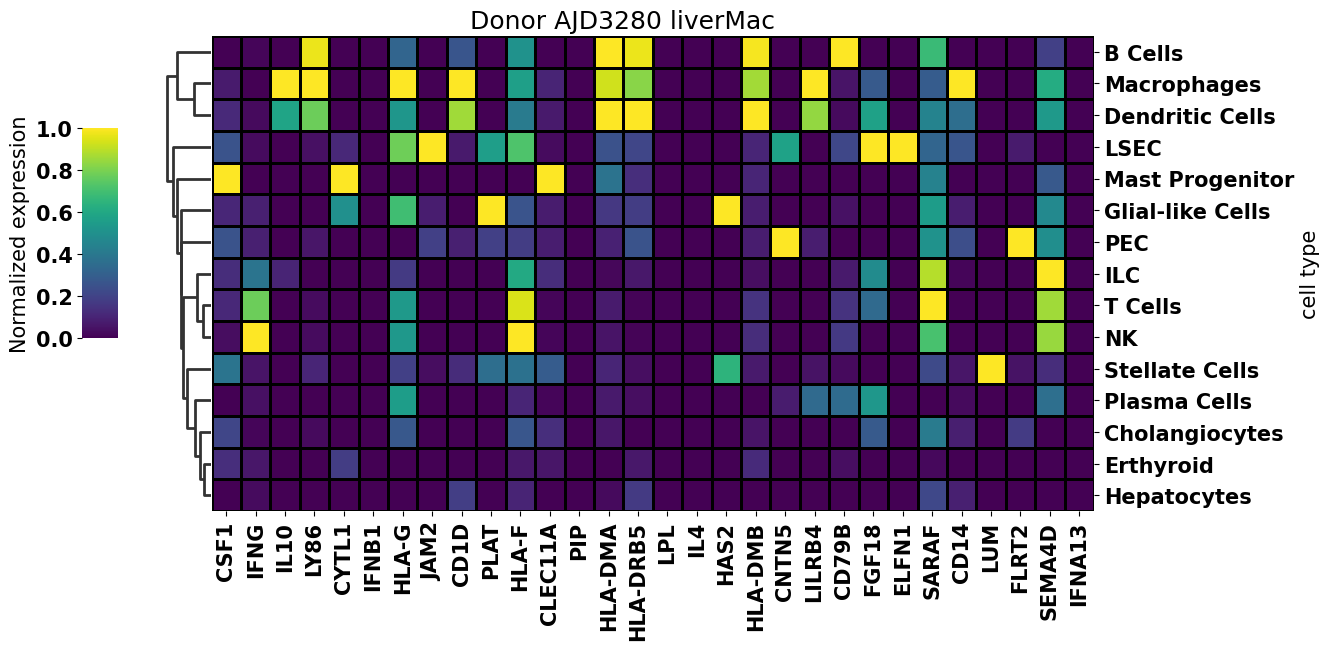

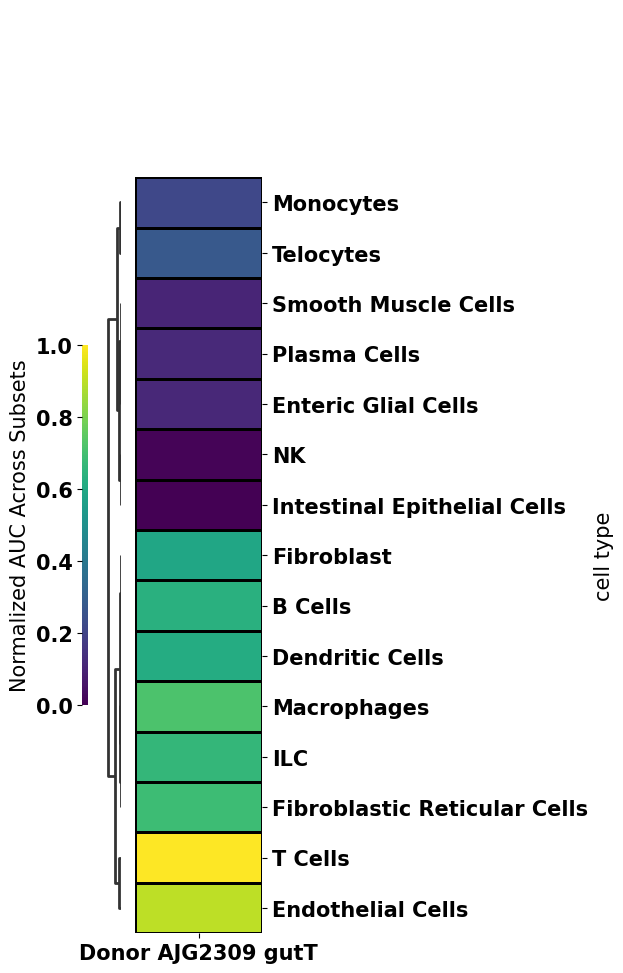

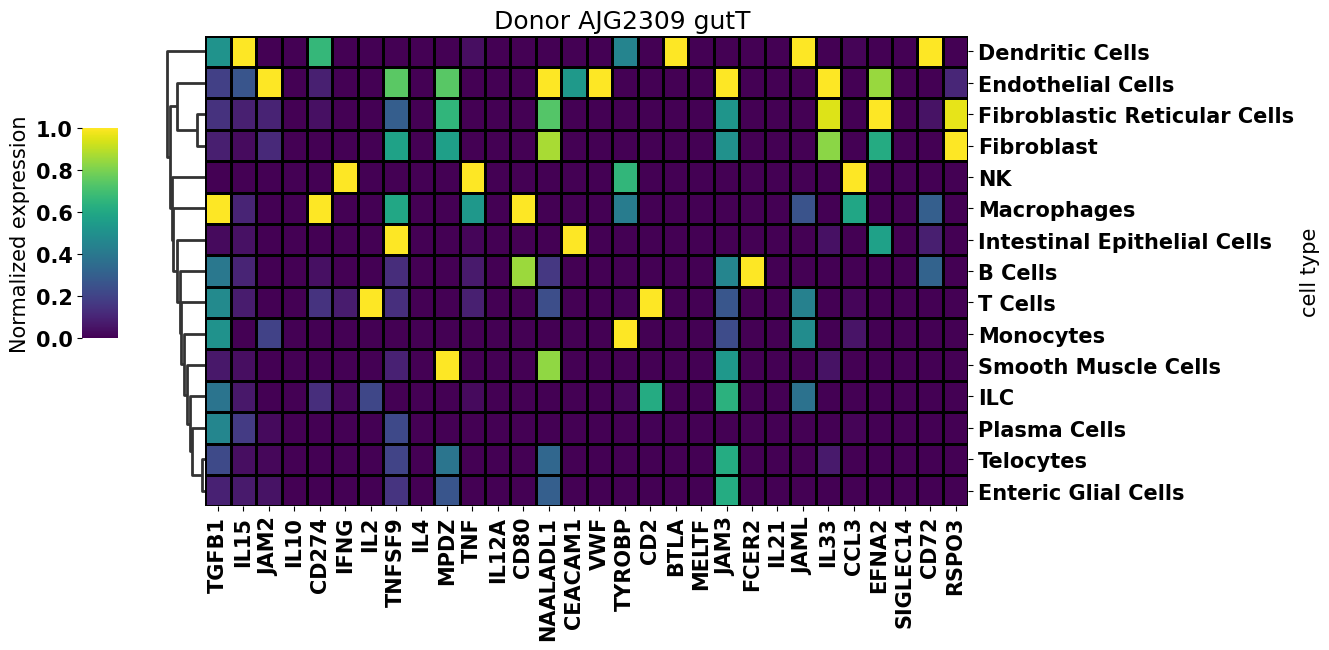

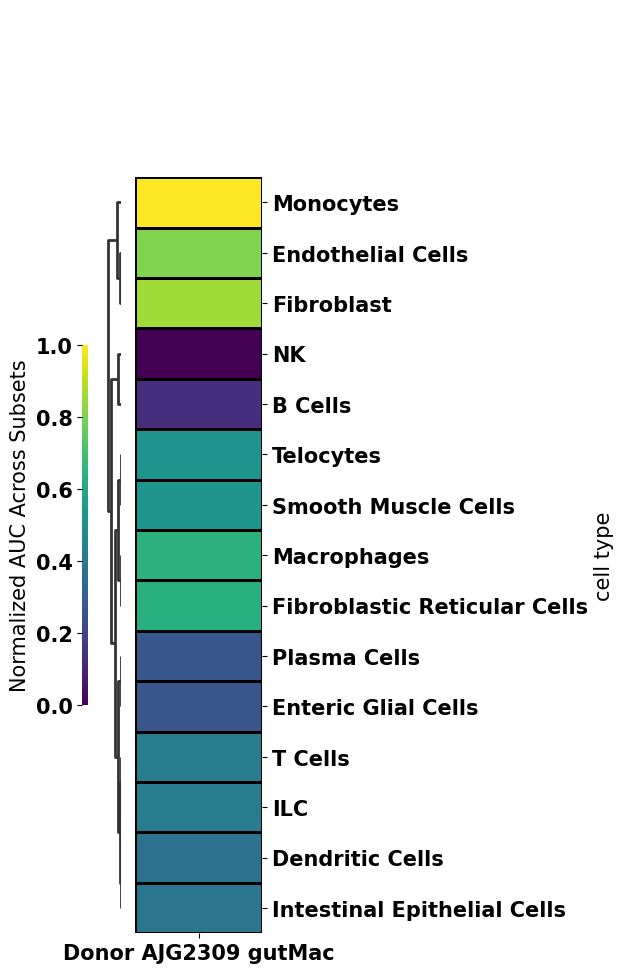

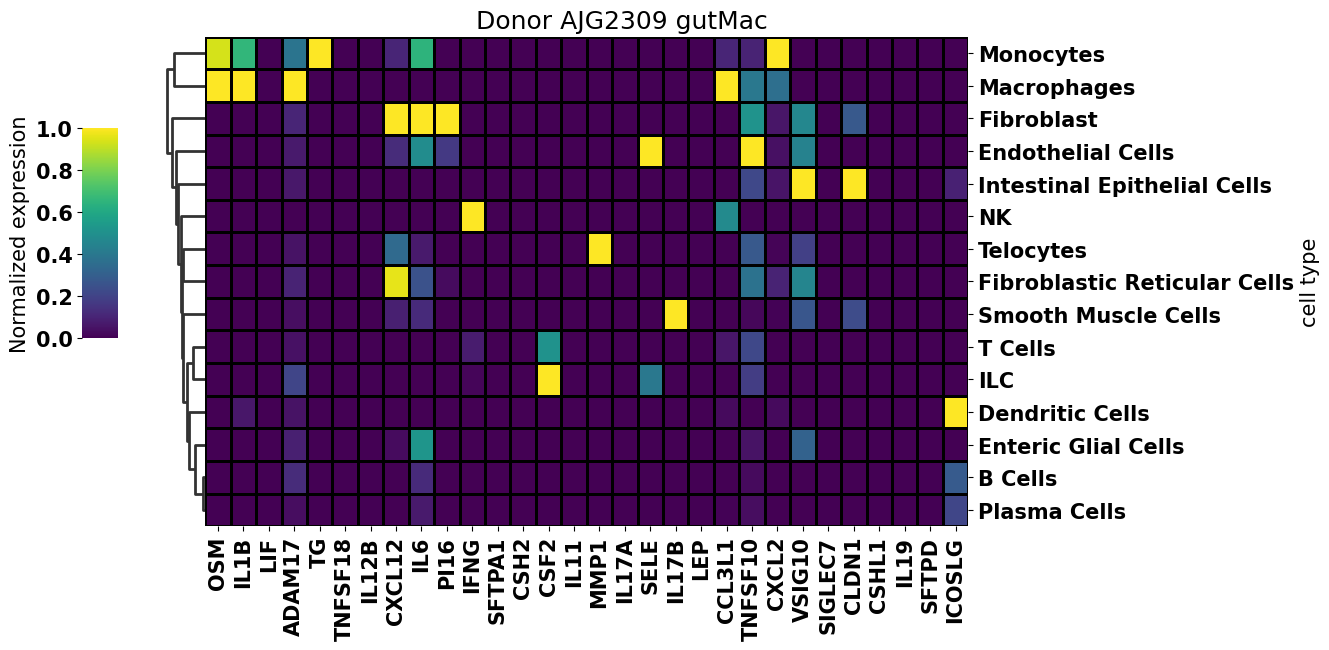

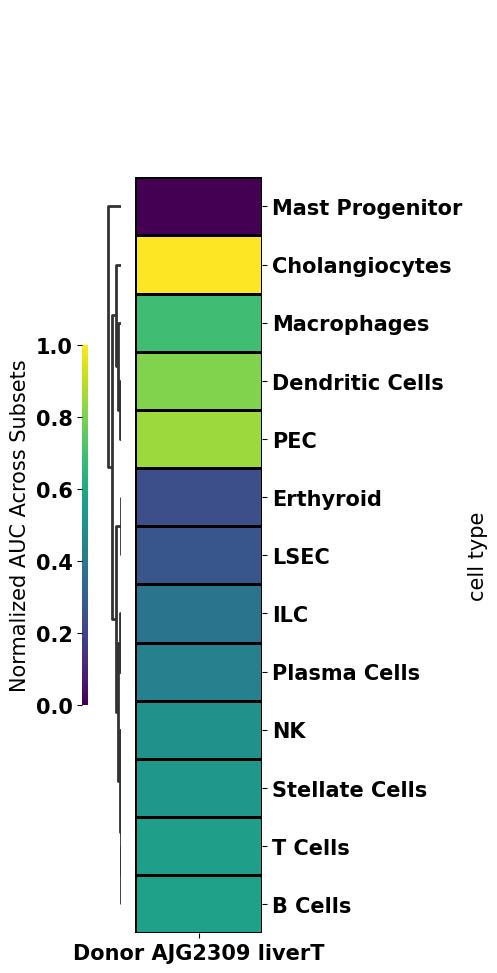

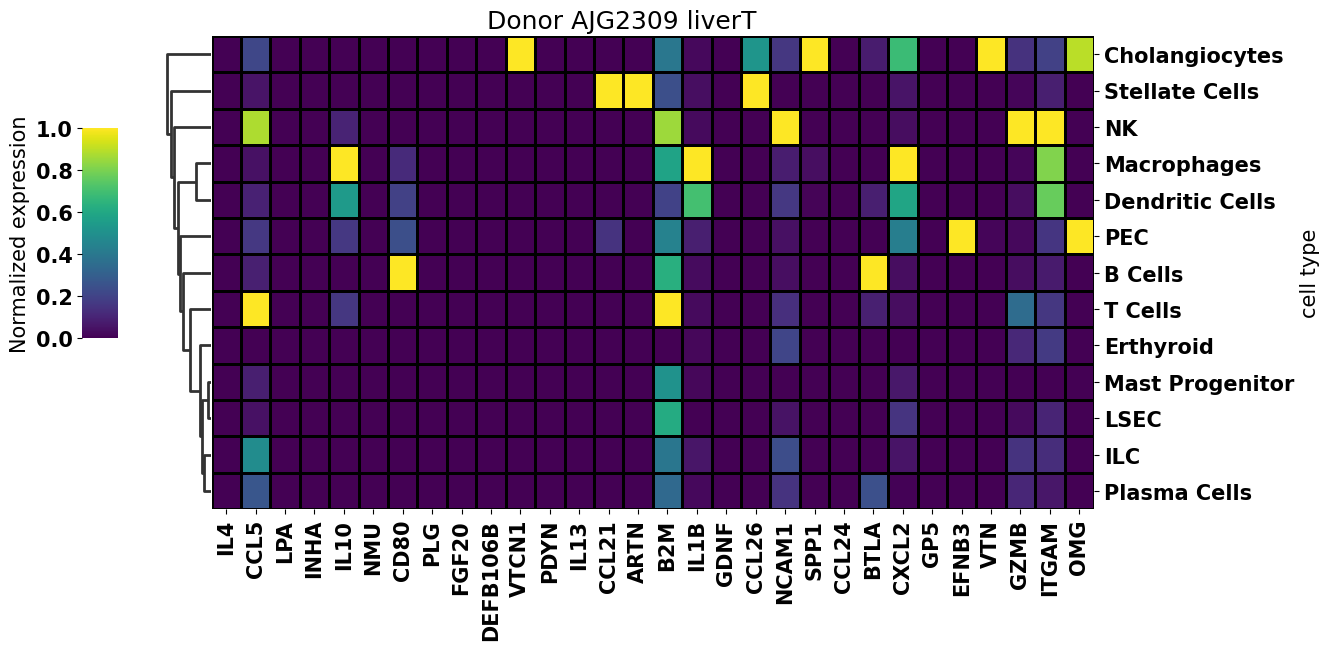

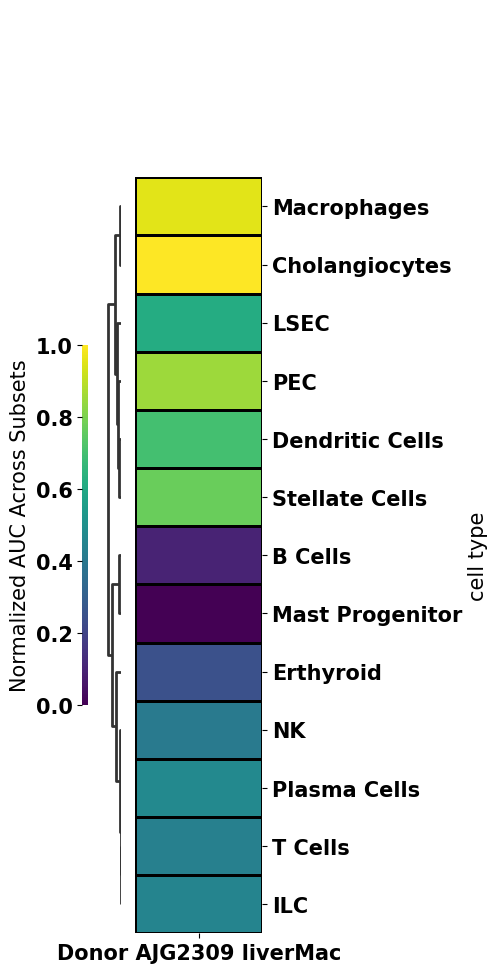

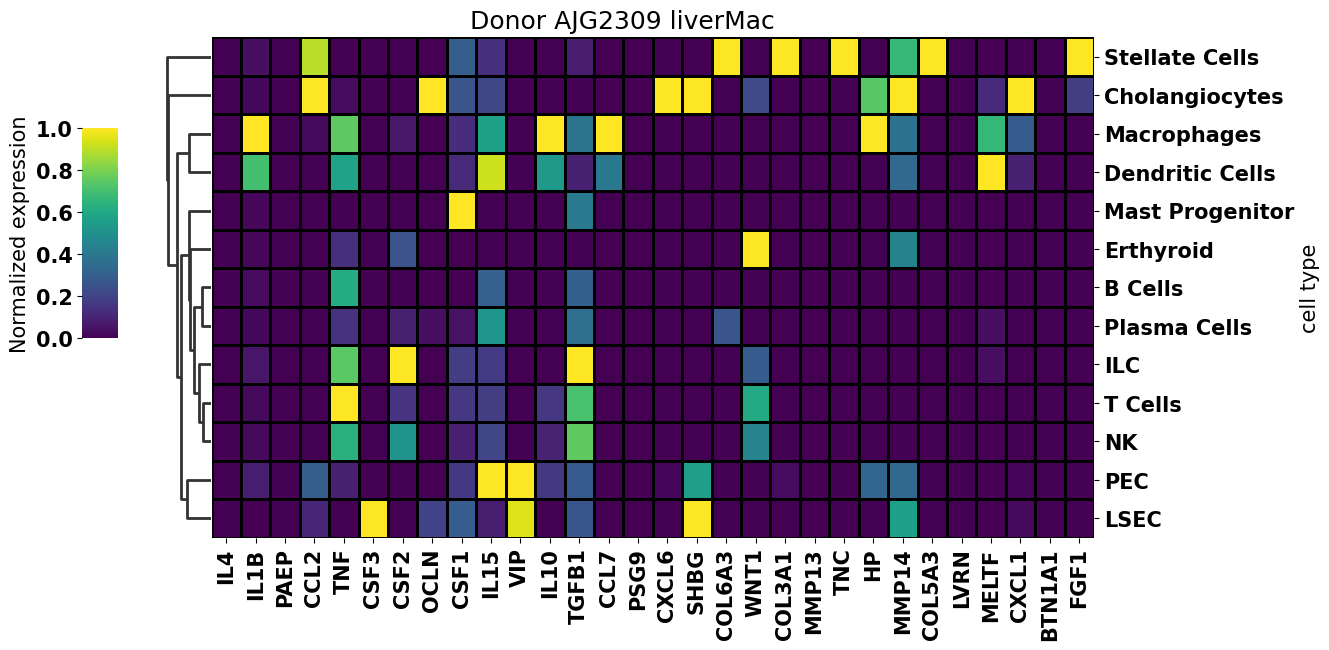

In [79]:
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
kwargs = {'cmap': 'viridis'}
#plt.rcParams.update(plt.rcParamsDefault)


donors = ['Donor AJD3280', 'Donor AJG2309']
donors_shs = ['3','4']
sites = ['gut','liver']
celltypes = ['T','Mac']
all_enrichment = {}
for di, donor in enumerate(donors):
    donor_sh = donors_shs[di]
    for site in sites:
        profile =  pd.read_csv('nichenet/profiles/'+donor+'_'+site+'_profile.csv',index_col = 0)
        for celltype in celltypes:
            # nichenet_filename = donor_sh+'_'+site+celltype
            nn_name = donor+' '+site+celltype
            target_genes = ligand_to_report[nn_name]
            enrichment = pd.DataFrame(index=profile.index, columns=[nn_name])
            for profile_celltype in range(profile.shape[0]):
                test_profile = pd.Series(profile.iloc[profile_celltype, :], index=profile.columns).to_dict()
                auc_value, recovery_curve = compute_recovery_auc(test_profile, target_genes)
                enrichment[nn_name][profile_celltype] = auc_value
            all_enrichment[nn_name] = enrichment
            enrichment = enrichment.astype('float')

            clustergrid = sns.clustermap(enrichment,figsize = (2,12),linewidths=2,standard_scale=1,
                        linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,
                        row_cluster = True,col_cluster = False,cbar_kws={'label': 'Normalized AUC Across Subsets','location':"left"},
                        **kwargs)
            for a in clustergrid.ax_row_dendrogram.collections:
                    a.set_linewidth(2)
            clustergrid.ax_cbar.set_position([0, 0.3, 0.03, 0.3])

            axs = clustergrid.fig.get_axes()
            for j in range(0,len(axs)): 
                axs[j].set_xlabel('')

            plt.savefig('vis/'+nn_name+'_ligand_auc.png',dpi = 300,bbox_inches='tight')


            heatmap_df =profile.reindex(columns = target_genes, fill_value=0)
            heatmap_df_norm = (heatmap_df-heatmap_df.min())/(heatmap_df.max()-heatmap_df.min()+0.000001)
            clustergrid = sns.clustermap(heatmap_df_norm,figsize = (12,7),linewidths=2,
                   linecolor = 'k',dendrogram_ratio = 0.05, colors_ratio = 0.5,vmax = 1, vmin = 0,
                   row_cluster = True,col_cluster = False,cbar_kws={'label': 'Normalized expression','location':"left"},
                   **kwargs)
            for a in clustergrid.ax_row_dendrogram.collections:
                a.set_linewidth(2)
            clustergrid.ax_cbar.set_position([-0.05, 0.5, 0.03, 0.3])

            axs = clustergrid.fig.get_axes()
            for j in range(0,len(axs)): 
                axs[j].set_xlabel('')
                clustergrid.fig.suptitle(nn_name, x= 0.4, y = 0.97, ha='center')
            plt.savefig('vis/'+nn_name+'_ligand_heat.png',dpi = 300,bbox_inches='tight')
            